In [ ]:
import torch 
import torch.nn.functional as F 
from torch import nn 
from torchsummary import summary 
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#%cd '/content/drive' # change directory to wherever train_val_loaders.py is
!pip install pretty_midi

os.chdir("/content/drive/MyDrive/ECE324_project") # for Richard
#%cd '/content/drive/My Drive' # for Anthony
!pwd
!ls
from train_val_loaders import *
from accuracy_function import * 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1Fj_nQk_JePlcXToLjWbqW7zBLS0cu7eP/ECE324_project
 Accuracies_AccType1.png
 Accuracies_AccType2_WindowSize1.png
 accuracy_function.py
'AutoTranscriber: Project Proposal.gdoc'
 AutoTranscriber-recordings
'Brainstorm Ideas.gdoc'
'Final Report.gdoc'
 kats_data
 Loss.png
 MAESTRO
'Music for Kat to Play'
 Net.pt
'Presentation Slides.gslides'
'Project Proposal Slides.gslides'
'Project Proposal: Surf and Turf Dudes.gdoc'
'Prototype Timeline.gdoc'
 __pycache__
 rubric_proposal.pdf
 TotalData
 train_val_loaders.py


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

  from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Mon Nov 30 02:45:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    46W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class amtNetMk2(nn.Module): 
    def __init__(self, num_kernels=40):
        super().__init__() 
        self.n_layers = 1
        self.hidden_size=100
        
        self.cnn = nn.Sequential(
            # input batchsizex1x229x251
            nn.Conv2d(1, 10, (4, 4), padding=0),
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            # current shape batchsizex10x229x248
            nn.Conv2d(10, 10, (3, 3), padding=1), 
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape batchsizex10x57x248
            nn.Conv2d(10, 10, (3, 3), padding=1), 
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape 10x14x248
        )
    
        self.fc1 = nn.Sequential(
            #input shape is 1x34720
            nn.Linear((248*14*10), 24552),
            nn.Dropout(0.5),
            nn.BatchNorm1d(24552),
            nn.Sigmoid(),
        )
        
        # input shape is 248x110
        self.rnn = nn.GRU(input_size=99, hidden_size=90)
        
        self.fc2 = nn.Sequential(
            nn.Linear(248*90, 248*88), 
            nn.Dropout(0.5),
            nn.BatchNorm1d(248*88),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        #print(x.shape)
        x = self.cnn(x)
        #print(x.shape)
        #x = x.transpose(1, 3).flatten(-3)
        x = x.view(batch_size, -1)
        #print(x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = x.reshape(batch_size, 99, 248) 
        #print(x.shape)
        x = x.transpose(1, 2)
        #print(x.shape)
        x, a = self.rnn(x)
        #print(x.shape)
        #print(a.shape)
        x = x.transpose(1, 2).flatten(-2)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        x = x.reshape(batch_size, 88, 248)
        #print(x.shape)
        return x, a
    
    def init_hidden(self, batch_size, device):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 248, self.hidden_size).zero_().to(device)
        return hidden

In [ ]:
class amtNetMk3(nn.Module): 
    def __init__(self, num_kernels=40):
        super().__init__() 
        self.n_layers = 1
        self.hidden_size=100
        
        self.cnn = nn.Sequential(
            # input batchsizex1x229x126
            nn.Conv2d(1, 10, (3, 3), padding=0),
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            # current shape batchsizex10x229x124
            nn.Conv2d(10, 10, (3, 3), padding=1), 
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape batchsizex10x57x124
            nn.Conv2d(10, 10, (3, 3), padding=1), 
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape 10x14x124
        )
    
        self.fc1 = nn.Sequential(
            #input shape is 1x34720
            nn.Linear((124*14*10), int(124*88*1.5)),
            nn.Dropout(0.5),
            nn.BatchNorm1d(int(124*88*1.5)),
            nn.Sigmoid(),
        )
        
        # input shape is 248x110
        self.rnn = nn.GRU(input_size=int(88*1.5), hidden_size=100)
        
        self.fc2 = nn.Sequential(
            nn.Linear(124*100, 124*88), 
            nn.Dropout(0.5),
            nn.BatchNorm1d(124*88),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        #print(x.shape)
        x = self.cnn(x)
        #print(x.shape)
        #x = x.transpose(1, 3).flatten(-3)
        x = x.view(batch_size, -1)
        #print(x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = x.reshape(batch_size, int(88*1.5), 124) 
        #print(x.shape)
        x = x.transpose(1, 2)
        #print(x.shape)
        x, a = self.rnn(x)
        # print(x.shape)
        # print(a.shape)
        x = x.transpose(1, 2).flatten(-2)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        x = x.reshape(batch_size, 88, 124)
        #print(x.shape)
        return x, a
    
    def init_hidden(self, batch_size, device):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 124, self.hidden_size).zero_().to(device)
        return hidden

In [ ]:
class amtNetMk4(nn.Module): 
    def __init__(self, num_kernels=40):
        super().__init__() 
        self.n_layers = 1
        self.hidden_size=100
        
        self.cnn = nn.Sequential(
            # input batchsizex1x229x126
            nn.Conv2d(1, 20, (3, 3), padding=0),
            nn.BatchNorm2d(20), 
            nn.ReLU(), 
            # current shape batchsizex20x229x124
            nn.Conv2d(20, 20, (3, 3), padding=1), 
            nn.BatchNorm2d(20), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape batchsizex20x57x124
            nn.Conv2d(20, 20, (3, 3), padding=1), 
            nn.BatchNorm2d(20), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape 20x14x124
        )
    
        self.fc1 = nn.Sequential(
            #input shape is 1x34720
            nn.Linear((124*14*20), int(124*88*1.5)),
            nn.Dropout(0.5),
            nn.BatchNorm1d(int(124*88*1.5)),
            nn.Sigmoid(),
        )
        
        # input shape is 248x110
        self.rnn = nn.GRU(input_size=int(88*1.5), hidden_size=100)
        
        self.fc2 = nn.Sequential(
            nn.Linear(124*100, 124*88), 
            nn.Dropout(0.5),
            nn.BatchNorm1d(124*88),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        #print(x.shape)
        x = self.cnn(x)
        #print(x.shape)
        #x = x.transpose(1, 3).flatten(-3)
        x = x.view(batch_size, -1)
        #print(x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = x.reshape(batch_size, int(88*1.5), 124) 
        #print(x.shape)
        x = x.transpose(1, 2)
        #print(x.shape)
        x, a = self.rnn(x)
        # print(x.shape)
        # print(a.shape)
        x = x.transpose(1, 2).flatten(-2)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        x = x.reshape(batch_size, 88, 124)
        #print(x.shape)
        return x, a
    
    def init_hidden(self, batch_size, device):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 124, self.hidden_size).zero_().to(device)
        return hidden

In [ ]:
def getLoader(batchSize):
    # mean and std dev -32.1196136474609375 and 21.2591381072998046875 respectively
    trainPath = "./MAESTRO/train"
    valPath = "./MAESTRO/validation"
    testPath = "./MAESTRO/test"
    mean = -32.1196136474609375
    stdDev = 21.2591381072998046875
    trainLoader, valLoader, testLoader = get_data_loaders(trainPath, valPath, testPath, batchSize, mean=mean, std=stdDev)

    return trainLoader, valLoader, testLoader

In [ ]:
def getModels(learningRate, modelVer = 'Mk3', lossFuncType='BCE', optimizerType='RMSprop'):
    if modelVer == "Mk3":
        net = amtNetMk3()
    elif modelVer == "Mk4":
        net = amtNetMk4()

    if lossFuncType == 'CE':
        lossFunc = nn.CrossEntropyLoss()
    elif lossFuncType == 'BCE':
        lossFunc = nn.BCEWithLogitsLoss()
    
    if optimizerType == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
    elif optimizerType == 'RMSprop':
        optimizer = torch.optim.RMSprop(net.parameters(), lr=learningRate)
    elif optimizerType == 'SGD':
        optimizer = torch.optim.SGD(net.parameters(), lr=learningRate, momentum=0.9, nesterov=True)

    return net, lossFunc, optimizer

In [ ]:
def getAccuracy(preds, labels, batchSize, accuracyType="element", windowSize=1):
    if accuracyType == "element": 
        acc = elementacc((preds.cpu()).detach(), (labels.cpu()).detach())
    elif accuracyType == "frame":
        acc = accuracy((preds.cpu()).detach(), (labels.cpu()).detach(), window_size=windowSize)
    #print("leaving")
    return acc 

def evaluate(net, device, valLoader, lossFunc, batchSize, accuracyType, windowSize):
    valAccAvg = 0 
    valAcc = 0
    N = 0
    net.to(device)
    for data in valLoader:  
        net.eval()
        inputs = (data[0].unsqueeze(1)).to(device)
        labels = data[1].to(device)
        preds, finalH = net(inputs.float())
        valAcc += getAccuracy((preds.cpu()).detach(), ((labels.float()).cpu()).detach(), batchSize, accuracyType, windowSize)
        loss = lossFunc(input=preds.float(), target=labels.float())
        N += 1
    valAccAvg = valAcc/N 
    return valAccAvg, loss.item()

In [ ]:
def trainNet(numOfEpochs = 5, batchSize = 10, learningRate = 0.001, modelVer = "Mk2", lossFuncType = "BCE", optimizerType = "RMSprop"):
    torch.manual_seed(324)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running through " + str(device))

    print("Initializing dataloaders...")
    trainLoader, valLoader, testLoader = getLoader(batchSize)

    print("Initializing models...")
    net, lossFunc, optimizer = getModels(learningRate, modelVer, lossFuncType, optimizerType)
    net.to(device)
    
    lossRec = [] 
    N = 0

    torch.cuda.empty_cache()
    for epoch in range(0, numOfEpochs, 1):
        N = 0
        print("Computing epoch " + str(epoch) + "...")
        for data in trainLoader:  
            net.train()
            inputs = (data[0].unsqueeze(1)).to(device)
            labels = data[1].to(device)
            optimizer.zero_grad()
            preds, finalH = net(inputs)
            loss = lossFunc(input=preds, target=labels.float())
            loss.backward() 
            optimizer.step()
            if N%10 == 0: 
                print("Epoch:" + str(epoch) + " | batch #" + str(N) + " | Loss:" + str(loss))
            N += 1
        torch.save(net.state_dict(), "Net.pt")

    return True

In [ ]:
def trainNetWithAcc(numOfEpochs = 5, batchSize = 10, learningRate = 0.001, modelVer = "Mk2", lossFuncType = "BCE", optimizerType = "RMSprop", accuracyType = "element", windowSize = 1):
    torch.manual_seed(324)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running through " + str(device))

    print("Initializing dataloaders...")
    trainLoader, valLoader, testLoader = getLoader(batchSize)

    print("Initializing models...")
    net, lossFunc, optimizer = getModels(learningRate, modelVer, lossFuncType, optimizerType)
    net.to(device)
    
    trainLossRec = []
    trainAccRec = []
    valLossRec = []  
    valAccRec = []  
    trainTimeSteps = []
    valTimeSteps = []
    N = 0

    trainAccSum = 0

    torch.cuda.empty_cache()

    for epoch in range(0, numOfEpochs, 1):
        N = 0
        print("Computing epoch " + str(epoch) + "...")
        for data in trainLoader:  
            net.train()
            inputs = (data[0].unsqueeze(1)).to(device)
            labels = data[1].to(device)
            optimizer.zero_grad()
            preds, finalH = net(inputs)
            loss = lossFunc(input=preds, target=labels.float())
            loss.backward() 
            optimizer.step()
            trainAccSum += getAccuracy(preds, labels.float(), batchSize, accuracyType, windowSize)
            if N%25 == 0: 
                trainLossRec.append(loss.item())
                trainTimeSteps.append(N)
                if N == 0:
                    trainAccRec.append(trainAccSum)
                else:
                    trainAccRec.append(trainAccSum/25)
                trainAccSum = 0
                print("Epoch:" + str(epoch) + " | batch #" + str(N) +  " | Train Acc:" + str(trainAccRec[-1]) + " | Train Loss:" + str(trainLossRec[-1]))
                # valData = evaluate(net, device, valLoader, lossFunc, batchSize)
                # valAccRec.append(valData[0])
                # valLossRec.append(valData[1])
                # print("BeepBopWooooWeeee " + str(epoch) + " | Val Acc:" + str(valAccRec[-1]) + " | Val Loss:" + str(valLossRec[-1]))
            if N%25 == 0:
                valData = evaluate(net, device, valLoader, lossFunc, batchSize, accuracyType, windowSize)
                valAccRec.append(valData[0])
                valLossRec.append(valData[1])
                valTimeSteps.append(N)
                print("Epoch:" + str(epoch) + " | batch #" + str(N) +  " | Val Acc:" + str(valAccRec[-1]) + " | Val Loss:" + str(valLossRec[-1]))
            N += 1
    print("Training Loop Complete")
    print("Testing network...")
    testData = evaluate(net, device, testLoader, lossFunc, batchSize, accuracyType, windowSize)
    print("Test Acc:" + str(testData[0]) + " | Test Loss:" + str(testData[1]))
    torch.save(net.state_dict(), "Net.pt")

    return trainLossRec, trainAccRec, trainTimeSteps, valLossRec, valAccRec, valTimeSteps, testData

Running through cuda
Initializing dataloaders...
Initializing models...
Computing epoch 0...
Epoch:0 | batch #0 | Train Acc:0.0 | Train Loss:0.9562978148460388
Epoch:0 | batch #0 | Val Acc:0.0 | Val Loss:0.8410986065864563
Epoch:0 | batch #25 | Train Acc:0.0 | Train Loss:0.8961766958236694
Epoch:0 | batch #25 | Val Acc:0.020226177233963662 | Val Loss:0.8779411315917969
Epoch:0 | batch #50 | Train Acc:0.0003655913978494624 | Train Loss:0.859220564365387
Epoch:0 | batch #50 | Val Acc:0.05710048201705599 | Val Loss:0.8576275110244751
Epoch:0 | batch #75 | Train Acc:0.018946236559139785 | Train Loss:0.844188392162323
Epoch:0 | batch #75 | Val Acc:0.06664812754912867 | Val Loss:0.8438410758972168
Epoch:0 | batch #100 | Train Acc:0.0432258064516129 | Train Loss:0.8239126205444336
Epoch:0 | batch #100 | Val Acc:0.07610307749351129 | Val Loss:0.825430154800415
Epoch:0 | batch #125 | Train Acc:0.05081720430107528 | Train Loss:0.8130373358726501
Epoch:0 | batch #125 | Val Acc:0.0817575083426029 

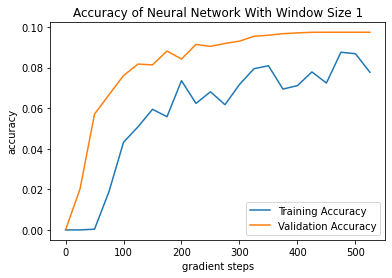

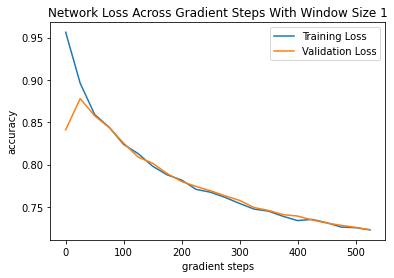

Running through cuda
Initializing dataloaders...
Initializing models...
Computing epoch 0...
Epoch:0 | batch #0 | Train Acc:0.0 | Train Loss:0.9562978148460388
Epoch:0 | batch #0 | Val Acc:0.0 | Val Loss:0.8410986065864563
Epoch:0 | batch #25 | Train Acc:0.0 | Train Loss:0.8959857225418091
Epoch:0 | batch #25 | Val Acc:0.04021134593993326 | Val Loss:0.8797509074211121
Epoch:0 | batch #50 | Train Acc:0.0003010752688172043 | Train Loss:0.8593477010726929
Epoch:0 | batch #50 | Val Acc:0.08767148683722653 | Val Loss:0.8581013083457947
Epoch:0 | batch #75 | Train Acc:0.034258064516129026 | Train Loss:0.8442013263702393
Epoch:0 | batch #75 | Val Acc:0.10978865406006671 | Val Loss:0.8440384864807129
Epoch:0 | batch #100 | Train Acc:0.0738494623655914 | Train Loss:0.8239994645118713
Epoch:0 | batch #100 | Val Acc:0.13568780126066002 | Val Loss:0.824902355670929
Epoch:0 | batch #125 | Train Acc:0.08316129032258067 | Train Loss:0.8131453990936279
Epoch:0 | batch #125 | Val Acc:0.1368928439006303

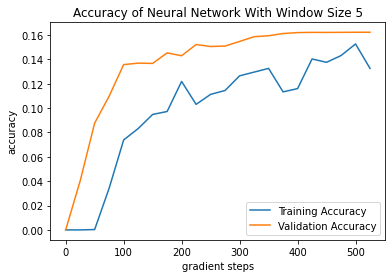

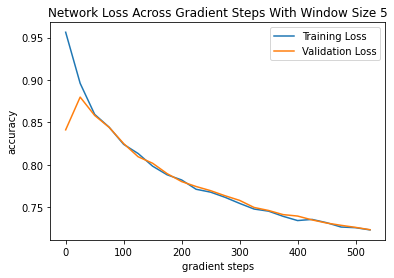

Running through cuda
Initializing dataloaders...
Initializing models...
Computing epoch 0...
Epoch:0 | batch #0 | Train Acc:0.0 | Train Loss:0.9562978148460388
Epoch:0 | batch #0 | Val Acc:0.0 | Val Loss:0.8410986065864563
Epoch:0 | batch #25 | Train Acc:0.0 | Train Loss:0.8959692716598511
Epoch:0 | batch #25 | Val Acc:0.033110863922877265 | Val Loss:0.8814599514007568
Epoch:0 | batch #50 | Train Acc:0.0009462365591397851 | Train Loss:0.8592304587364197
Epoch:0 | batch #50 | Val Acc:0.1353170189098999 | Val Loss:0.858666718006134
Epoch:0 | batch #75 | Train Acc:0.04929032258064515 | Train Loss:0.8441670536994934
Epoch:0 | batch #75 | Val Acc:0.15378197997775303 | Val Loss:0.8435224294662476
Epoch:0 | batch #100 | Train Acc:0.10582795698924731 | Train Loss:0.823932945728302
Epoch:0 | batch #100 | Val Acc:0.17423062662217276 | Val Loss:0.8247679471969604
Epoch:0 | batch #125 | Train Acc:0.11322580645161291 | Train Loss:0.8129956722259521
Epoch:0 | batch #125 | Val Acc:0.17845754542083797

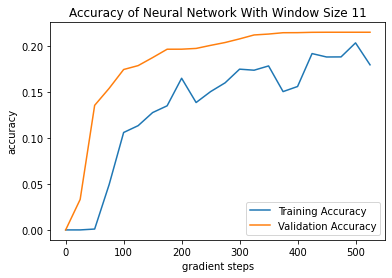

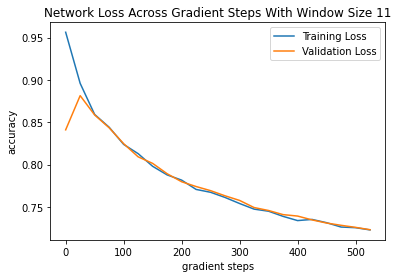

Running through cuda
Initializing dataloaders...
Initializing models...
Computing epoch 0...
Epoch:0 | batch #0 | Train Acc:0.0 | Train Loss:0.9562978148460388
Epoch:0 | batch #0 | Val Acc:0.0 | Val Loss:0.8410986065864563
Epoch:0 | batch #25 | Train Acc:0.0 | Train Loss:0.8960209488868713
Epoch:0 | batch #25 | Val Acc:0.16420096403411197 | Val Loss:0.8800971508026123
Epoch:0 | batch #50 | Train Acc:0.0012473118279569893 | Train Loss:0.8593102693557739
Epoch:0 | batch #50 | Val Acc:0.2993140526510938 | Val Loss:0.8556345701217651
Epoch:0 | batch #75 | Train Acc:0.09883870967741934 | Train Loss:0.8442028760910034
Epoch:0 | batch #75 | Val Acc:0.3448646644419726 | Val Loss:0.8437117338180542
Epoch:0 | batch #100 | Train Acc:0.22488172043010748 | Train Loss:0.8239643573760986
Epoch:0 | batch #100 | Val Acc:0.4005005561735261 | Val Loss:0.8251624703407288
Epoch:0 | batch #125 | Train Acc:0.26098924731182793 | Train Loss:0.8129803538322449
Epoch:0 | batch #125 | Val Acc:0.393047830923248 | 

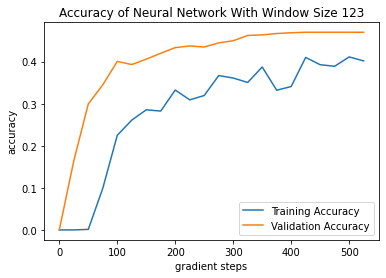

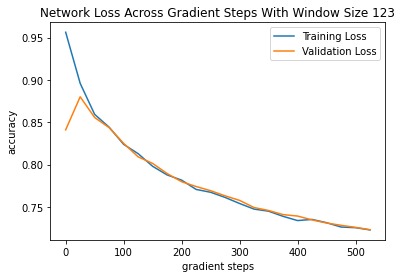

In [ ]:
windowSizes = [1, 5, 11, 123]
for size in windowSizes:
    torch.cuda.empty_cache()
    trainLossRec, trainAccRec, trainTimeSteps, valLossRec, valAccRec, valTimeSteps, testData = trainNetWithAcc(numOfEpochs=1, batchSize=15, learningRate=0.005, modelVer="Mk3", lossFuncType="BCE", optimizerType="RMSprop", accuracyType="frame", windowSize=size)

    plt.figure()
    plt.plot(trainTimeSteps, trainAccRec, label='Training Accuracy')
    plt.plot(valTimeSteps, valAccRec, label='Validation Accuracy')
    plt.xlabel("gradient steps")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("Accuracy of Neural Network With Window Size " + str(size))
    plt.savefig("Accuracies_AccType2_WindowSize" + str(size) + ".png")
    plt.show()

    plt.figure()
    plt.plot(trainTimeSteps, trainLossRec, label='Training Loss')
    plt.plot(valTimeSteps, valLossRec, label='Validation Loss')
    plt.xlabel("gradient steps")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("Network Loss Across Gradient Steps With Window Size " + str(size))
    plt.savefig("Loss_WindowSize" + str(size) + ".png")
    plt.show()

In [ ]:
torch.cuda.empty_cache()
trainLossRec, trainAccRec, trainTimeSteps, valLossRec, valAccRec, valTimeSteps, testData = trainNetWithAcc(numOfEpochs=1, batchSize=15, learningRate=0.005, modelVer="Mk3", lossFuncType="BCE", optimizerType="RMSprop")

Running through cuda
Initializing dataloaders...
Initializing models...
Computing epoch 0...
Epoch:0 | batch #0 | Train Acc:0.5001466275659824 | Train Loss:0.9562978148460388
Epoch:0 | batch #0 | Val Acc:0.7261843968045304 | Val Loss:0.8410986065864563
Epoch:0 | batch #25 | Train Acc:0.533239247311828 | Train Loss:0.8958936929702759
Epoch:0 | batch #25 | Val Acc:0.9218211733576026 | Val Loss:0.8798230886459351
Epoch:0 | batch #50 | Train Acc:0.787147605083089 | Train Loss:0.8592432737350464
Epoch:0 | batch #50 | Val Acc:0.9330002612330199 | Val Loss:0.857650876045227
Epoch:0 | batch #75 | Train Acc:0.9151439393939396 | Train Loss:0.8442455530166626
Epoch:0 | batch #75 | Val Acc:0.9379660059999323 | Val Loss:0.8434765338897705
Epoch:0 | batch #100 | Train Acc:0.9245584066471164 | Train Loss:0.8239358067512512
Epoch:0 | batch #100 | Val Acc:0.9409057201604478 | Val Loss:0.8251491189002991
Epoch:0 | batch #125 | Train Acc:0.9282412023460412 | Train Loss:0.8130138516426086
Epoch:0 | batch 

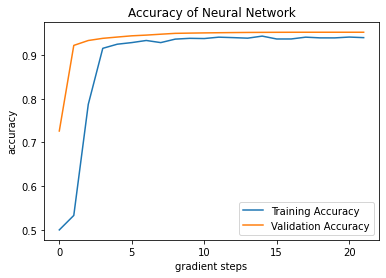

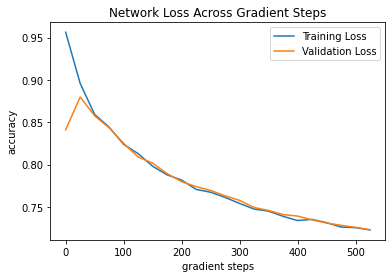

In [ ]:
plt.figure()
plt.plot(trainAccRec, label='Training Accuracy')
plt.plot(valAccRec, label='Validation Accuracy')
plt.xlabel("gradient steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy of Neural Network")
plt.savefig("Accuracies_AccType1.png")
plt.show()

plt.figure()
plt.plot(trainTimeSteps, trainLossRec, label='Training Loss')
plt.plot(trainTimeSteps, valLossRec, label='Validation Loss')
plt.xlabel("gradient steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("Network Loss Across Gradient Steps")
plt.savefig("Loss.png")
plt.show()

In [ ]:
torch.cuda.empty_cache()
trainLossRec2, trainAccRec2, trainTimeSteps2, valLossRec2, valAccRec2, valTimeSteps2, testData = trainNetWithAcc(numOfEpochs=1, batchSize=15, learningRate=0.005, modelVer="Mk3", lossFuncType="BCE", optimizerType="RMSprop", accuracyType="frame")

In [ ]:
plt.figure()
plt.plot(trainAccRec2, trainTimeSteps2, label='Training Accuracy')
plt.plot(validAccRec2, trainTimeSteps2, label='Validation Accuracy')
plt.xlabel("gradient steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy of Neural Network")
plt.savefig("Accuracies_AccType1.png")
plt.show()

plt.figure()
plt.plot(trainLossRec2, trainTimeSteps2, label='Training Loss')
plt.plot(validLossRec2, trainTimeSteps2, label='Validation Loss')
plt.xlabel("gradient steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("Network Loss Across Gradient Steps")
plt.savefig("Loss.png")
plt.show()


In [ ]:
net = amtNetMk4()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inp = torch.randn(1, 229, 126)
summary(net.to(device), (1, 229, 126))

# Disregard code below this cell
Destructuring trainNet function so I don't need to recompute heavy portions of code everytime, will merge into unified function later

In [ ]:
batchSize = 8
trainLoader, valLoader, testLoader = getLoader(batchSize)

In [ ]:
for data, labels in (trainLoader):
    print(data)
    break

In [ ]:
net = amtNetMk2()
torch.save(net.state_dict(), "Net.pt")
print("done")

done


In [ ]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inp = torch.randn(10, 1, 229, 251)


# if torch.cuda.is_available():
#     model.cuda()

#out, res = model(inp)
res = model(inp)

In [ ]:
print(model)

basicNetMk2(
  (cnn): Sequential(
    (0): Conv2d(1, 10, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.25, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=69440, out_features=32736, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
  )
  (rnn): GRU(132, 1

In [ ]:
class amtNetMk1(nn.Module): 
    def __init__(self, num_kernels=40):
        super().__init__() 
        
        self.cnn = nn.Sequential(
            # input batchsizex1x229x626
            nn.Conv2d(1, 10, (3, 3), padding=1),
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            # current shape batchsizex229x10x626
            nn.Conv2d(10, 10, (3, 3), padding=1), 
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape batchsizex57x626x10
            nn.Conv2d(10, 20, (3, 3), padding=1), 
            nn.BatchNorm2d(20), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape 14x626x20
        )
    
        self.fc1 = nn.Sequential(
            nn.Linear((626*20*14), 3130),
            nn.Dropout(0.5),
            # Code calls for another batch norm here but unsure what to specifically normalize here
            nn.Sigmoid(),
        )
        
        self.rnn = nn.GRU(input_size=626, hidden_size=626) # hidden_size is num of features 
        
        self.fc2 = nn.Sequential(
            nn.Linear((626*5), 626*3), 
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        print(batch_size)
        print(x.shape)
        x = self.cnn(x)
        print(x.shape)
        x = x.transpose(1, 3).flatten(-3)
        print(x.shape)
        x = self.fc1(x)
        print(x.shape)
        x = x.reshape(batch_size, 5, 626) 
        print(x.shape)
        a, x = self.rnn(x)
        print(x.shape)
        print(a.shape)
        x = x.transpose(1, 2).flatten(-2)
        print(x.shape)
        print(a.shape)
        x = self.fc2(x)
        print(x.shape)
        x = x.reshape(batch_size, 3, 626)
        print(x.shape)
        return x

The mean and standard deviation I got for the training data was -32.1196136474609375 and 21.2591381072998046875 respectively.